In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
BD_NAME = 'export_20220921060002.csv'
BD_FOLDER = './data'
VERSION = 'v2.2.220921'
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-17'

In [6]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [7]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663739916,35454,51719,sell,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,NaN,0.86,sneakers,common,sprinter,...,375.0,8250.0,27085,7009,744,3204,6054,10690,88.0,1.490798
1,1663739904,35453,21750,sell,0x0d97edb2df1e0a787f358329aad04c00d83987b6,NaN,0.92,sneakers,common,hiker,...,374.0,8250.0,27085,8172,744,3204,6054,10690,88.0,1.500000
2,1663739778,35233,42053,cancel,0x980f18d18293290117d3b5f1f326ecb754f3b1fe,NaN,NaN,sneakers,uncommon,sprinter,...,376.0,8250.0,27085,7009,745,3204,6055,10691,88.0,1.496933
3,1663739769,35226,47193,cancel,0x980f18d18293290117d3b5f1f326ecb754f3b1fe,NaN,NaN,sneakers,uncommon,hiker,...,376.0,8250.0,27085,8172,745,3204,6056,10691,88.0,1.496933
4,1663739754,35225,51156,cancel,0xf61a9f0c9b3888e6898411c07b02db72c517386f,NaN,NaN,sneakers,uncommon,hiker,...,376.0,8250.0,27085,8172,745,3204,6056,10691,88.0,1.509202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41571,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
41572,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
41573,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
41574,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [8]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [9]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41576 entries, 0 to 41575
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  30889 non-null  float64
 1   time_ownership             30889 non-null  float64
 2   wallet_box_mint            30889 non-null  float64
 3   wallet_sneaker_mint        30889 non-null  float64
 4   time_level_up              28147 non-null  float64
 5   time_level_up_for_mint     30889 non-null  float64
 6   base_mint_price_amt        30889 non-null  float64
 7   base_mint_price_azy        30889 non-null  float64
 8   base_mint_price_bnb        20866 non-null  float64
dtypes: float64(9)
memory usage: 2.9 MB


In [10]:
data.genesis

0        False
1         True
2        False
3        False
4        False
         ...  
41571     True
41572    False
41573    False
41574    False
41575     True
Name: genesis, Length: 41576, dtype: bool

In [11]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1663739253,35443,49180,buy,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,0x7e4e20561fcec9a545d3faaf64851a5e78494cb7,0.78,sneakers,common,ranger,...,377.0,8250.0,27084,7505,748,3205,6057,10692,87.0,1.521472
17,1663739163,35445,51137,buy,0x60f16840bf3fb04074333b836d22822002b45704,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.80,sneakers,common,ranger,...,379.0,8249.0,27084,7505,749,3207,6057,10692,87.0,1.524390
21,1663739073,35340,29347,buy,0x674426edd6985de6e3b860902e6765c51a69b33e,0x60f16840bf3fb04074333b836d22822002b45704,0.80,sneakers,common,hiker,...,378.0,8250.0,27084,8172,752,3208,6057,10692,87.0,1.521472
24,1663738986,35437,21901,buy,0xec6673229743549642fe6dd7a3117be5d8b377d4,0xad728e59e1b735398f3f2b7a59b9d5a1a651f2db,0.79,sneakers,common,hiker,...,378.0,8250.0,27084,8172,754,3208,6057,10692,87.0,1.496970
35,1663738833,35432,25523,buy,0x34bf260019ddef3574c1e886f3b6e3895f277b84,0x312d5b8c02b1e4a1c414fe4dde3fa2fe390edaf9,0.97,sneakers,common,hiker,...,383.0,8249.0,27084,8172,756,3209,6057,10693,87.0,1.506024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41513,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
41536,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
41550,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
41555,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [12]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [13]:
data['mint'].isna().sum()

0

In [14]:
data[data['level'] == 9]['mint'].value_counts()

2.0    97
0.0    50
3.0    27
1.0    18
Name: mint, dtype: int64

In [15]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
406,1663718884,34943,17827,buy,0xd289e208d1e602aed463f10f6f7c2d0c136f6333,0x6fe844ec6adaed27195686039ab6247c3497d5e0,3.00,sneakers,common,coacher,...,421.0,8235.0,27048,4397,756,3199,6047,10683,86.0,1.230769
486,1663715605,34801,16261,buy,0x28bcc3f3b8852f3c3f31f87b1a1bca61044ec481,0x26d409a0bdef03cef0fabc738b12df86d8a40ce7,2.00,sneakers,common,coacher,...,421.0,8233.0,27037,4396,754,3193,6044,10673,85.0,1.188679
914,1663702329,34934,24226,buy,0x148960216a0c880304658b9132308f1ee1a43e69,0x2d44b26165fb1ec036258919133001a5e71c568d,1.18,sneakers,common,sprinter,...,456.0,8216.0,26968,6963,812,3168,6033,10654,92.0,1.119266
1912,1663661964,34301,14677,buy,0x5a2168c18008a6eaef825dcac9a3d9844ba715a4,0x2100beb1eea62498a605fa447eb3e86e3a981ec3,1.47,sneakers,common,ranger,...,384.0,8175.0,26379,7297,457,2782,5604,10212,85.0,1.022472
2113,1663640451,34074,26338,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0xeefc7b5d629fa95f907bc5cb07f61d0d61b6ba09,1.95,sneakers,common,coacher,...,388.0,8159.0,26307,4340,457,2769,5595,10243,92.0,1.016949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,17470,4485,311,2399,6350,17470,NaN,NaN
37724,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,17224,4417,284,2324,6191,17224,NaN,NaN
38877,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,16921,3733,531,5201,6000,16921,NaN,NaN
39238,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,16746,3720,452,5118,5868,16746,NaN,NaN


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8326 non-null   int64  
 1   mrk_id                                           8326 non-null   int64  
 2   token_id                                         8326 non-null   int64  
 3   event                                            8326 non-null   object 
 4   wallet_from                                      8326 non-null   object 
 5   wallet_to                                        8326 non-null   object 
 6   price                                            8326 non-null   float64
 7   item_type                                        8326 non-null   object 
 8   rarity                                           8326 non-null   object 
 9   sneaker_type                

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  8326 non-null   float64
 1   time_ownership             8326 non-null   float64
 2   wallet_box_mint            8326 non-null   float64
 3   wallet_sneaker_mint        8326 non-null   float64
 4   time_level_up              8326 non-null   float64
 5   time_level_up_for_mint     8326 non-null   float64
 6   base_mint_price_amt        8326 non-null   float64
 7   base_mint_price_azy        8326 non-null   float64
 8   base_mint_price_bnb        5936 non-null   float64
dtypes: float64(9)
memory usage: 650.5 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
15,1.657801e+09,282.0,6.0,4.0,900.0,1800.0,300.0,200.0,0.661364
17,1.657800e+09,376168.0,9.0,9.0,0.0,1800.0,300.0,200.0,0.661364
21,1.657839e+09,10155.0,5.0,5.0,1260.0,1800.0,300.0,200.0,0.661364
24,1.657810e+09,306.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.661364
35,1.657811e+09,522.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.660887
...,...,...,...,...,...,...,...,...,...
41513,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
41536,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
41550,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
41555,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8326 entries, 15 to 41569
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8326 non-null   int64  
 1   mrk_id                                           8326 non-null   int64  
 2   token_id                                         8326 non-null   int64  
 3   event                                            8326 non-null   object 
 4   wallet_from                                      8326 non-null   object 
 5   wallet_to                                        8326 non-null   object 
 6   price                                            8326 non-null   float64
 7   item_type                                        8326 non-null   object 
 8   rarity                                           8326 non-null   object 
 9   sneaker_type                

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
15,1663739253,35443,49180,buy,0x90e19f892f141e2ca755e7bf07aee5b4f5bb0b7d,0x7e4e20561fcec9a545d3faaf64851a5e78494cb7,0.78,sneakers,common,ranger,...,377.0,8250.0,27084,7505,748,3205,6057,10692,87.0,1.521472
17,1663739163,35445,51137,buy,0x60f16840bf3fb04074333b836d22822002b45704,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.80,sneakers,common,ranger,...,379.0,8249.0,27084,7505,749,3207,6057,10692,87.0,1.524390
21,1663739073,35340,29347,buy,0x674426edd6985de6e3b860902e6765c51a69b33e,0x60f16840bf3fb04074333b836d22822002b45704,0.80,sneakers,common,hiker,...,378.0,8250.0,27084,8172,752,3208,6057,10692,87.0,1.521472
24,1663738986,35437,21901,buy,0xec6673229743549642fe6dd7a3117be5d8b377d4,0xad728e59e1b735398f3f2b7a59b9d5a1a651f2db,0.79,sneakers,common,hiker,...,378.0,8250.0,27084,8172,754,3208,6057,10692,87.0,1.496970
35,1663738833,35432,25523,buy,0x34bf260019ddef3574c1e886f3b6e3895f277b84,0x312d5b8c02b1e4a1c414fe4dde3fa2fe390edaf9,0.97,sneakers,common,hiker,...,383.0,8249.0,27084,8172,756,3209,6057,10693,87.0,1.506024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41513,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
41536,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
41550,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
41555,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [27]:
data_tmp = data[data['wallet_to'] == '0x3273af210822c44afd7254510e612e4dbb1040a7']
data_tmp

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
28237,1662053291,20476,31507,buy,0xda8d9bb6bc7435aab34e42e67f888aafff18460e,0x3273af210822c44afd7254510e612e4dbb1040a7,0.75,sneakers,common,ranger,...,NaN,19343,5083,300,1445,4052,14441,NaN,NaN,2022-09-01 17:28:11
28164,1662056052,20503,32047,buy,0xa721a33719de1eb7b3e5213baa9a78a0bf77ed89,0x3273af210822c44afd7254510e612e4dbb1040a7,0.81,sneakers,common,hiker,...,NaN,19356,5431,311,1455,4055,14421,NaN,NaN,2022-09-01 18:14:12
27256,1662104226,20969,16805,buy,0xbbffe5a1bde7086ce10ebf16dada29ea3d098097,0x3273af210822c44afd7254510e612e4dbb1040a7,1.10,sneakers,common,coacher,...,NaN,19516,3929,401,1536,4080,14078,NaN,NaN,2022-09-02 07:37:06
27071,1662110130,21065,33512,buy,0xc5ba284b870d6370f0a5abc28d610fe7a4fa954b,0x3273af210822c44afd7254510e612e4dbb1040a7,0.83,sneakers,common,sprinter,...,NaN,19535,4963,390,1535,4071,14069,NaN,NaN,2022-09-02 09:15:30
27000,1662114159,21103,33779,buy,0xfe543c294ca542ad18bdfbd55c16c48876f3b206,0x3273af210822c44afd7254510e612e4dbb1040a7,0.73,sneakers,common,hiker,...,NaN,19547,5495,365,1535,4068,14045,NaN,NaN,2022-09-02 10:22:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,1663716310,35191,29600,buy,0x9c54cdbf26743ed298eb43e9ea84e46394b8755a,0x3273af210822c44afd7254510e612e4dbb1040a7,0.73,sneakers,common,ranger,...,8234.0,27039,7489,751,3195,6046,10675,86.0,1.199052,2022-09-20 23:25:10
442,1663717660,35211,29345,buy,0xc421191eac24d628547aa41c4cb5b6245dc4eaca,0x3273af210822c44afd7254510e612e4dbb1040a7,0.73,sneakers,common,ranger,...,8234.0,27042,7489,751,3196,6042,10678,86.0,1.221154,2022-09-20 23:47:40
421,1663718362,35220,24757,buy,0x8b37fe4036b0622773fc3f3e712a0357b488ee41,0x3273af210822c44afd7254510e612e4dbb1040a7,0.67,sneakers,common,ranger,...,8235.0,27047,7489,756,3198,6046,10683,86.0,1.202899,2022-09-20 23:59:22
397,1663719157,35238,30260,buy,0xe6a8913f40d7e1332cf96d9c2716af02223ffb38,0x3273af210822c44afd7254510e612e4dbb1040a7,0.72,sneakers,common,ranger,...,8236.0,27048,7489,756,3199,6047,10683,86.0,1.240385,2022-09-21 00:12:37


In [28]:
data_tmp.index = data_tmp.date

In [37]:
data_tmp[(data_tmp.date >= '2022-09-01')].date.dt.day.value_counts()

20    35
2     23
10    16
9     13
4     11
11    10
12    10
8      8
19     8
6      7
16     6
13     6
7      5
15     5
3      4
1      2
14     2
5      2
21     2
18     1
Name: date, dtype: int64

In [48]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [49]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [50]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [51]:
#data['bin_level'].value_counts()

In [52]:
#data['bin_mint'].value_counts()

In [53]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [54]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [55]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [56]:
data['token_sell_activity_6H'].max()

11

In [57]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [58]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [59]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

4306

In [60]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [61]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
25588,277.756081,0.113478,0.552838,0.678822
25587,277.756081,0.113478,0.552838,0.678822
25581,278.034632,0.112454,0.552219,0.676738
25579,278.034632,0.112460,0.552195,0.676716
25567,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
6524,275.141287,0.082561,0.553746,0.663789
6517,274.804693,0.082530,0.553932,0.664784
6515,274.665829,0.082518,0.553828,0.664998
6513,274.665829,0.082518,0.553828,0.664998


In [62]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [63]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
25588,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
25587,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
25581,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
25579,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
25567,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6524,275.141287,0.082561,0.553746,1.658244e+09,207178.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.663789,2022-09-16 23:29:21
6517,274.804693,0.082530,0.553932,1.660494e+09,2877919.0,0.0,1.0,0.0,1800.0,300.0,200.0,0.664784,2022-09-16 23:41:15
6515,274.665829,0.082518,0.553828,1.657805e+09,633.0,9.0,27.0,0.0,1800.0,300.0,200.0,0.664998,2022-09-16 23:43:54
6513,274.665829,0.082518,0.553828,1.660664e+09,84.0,2.0,3.0,1260.0,1800.0,300.0,200.0,0.664998,2022-09-16 23:45:45


In [64]:
train_data.base_mint_price_azy.value_counts()

200.0     4033
800.0      271
3200.0       2
Name: base_mint_price_azy, dtype: int64

In [65]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [66]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [67]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

30it [00:49,  1.66s/it]


In [68]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.895,0.0634
MAE,0.102,0.0154
MSE,0.155,0.1427
RMSE,0.364,0.1535
MAPE,0.066,0.0069


In [69]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.895,0.0634
MAE,0.102,0.0154
MSE,0.155,0.1427
RMSE,0.364,0.1535
MAPE,0.066,0.0069


In [70]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.887, 'MAE': 0.102, 'MSE': 0.155, 'RMSE': 0.394, 'MAPE': 0.066}

In [71]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

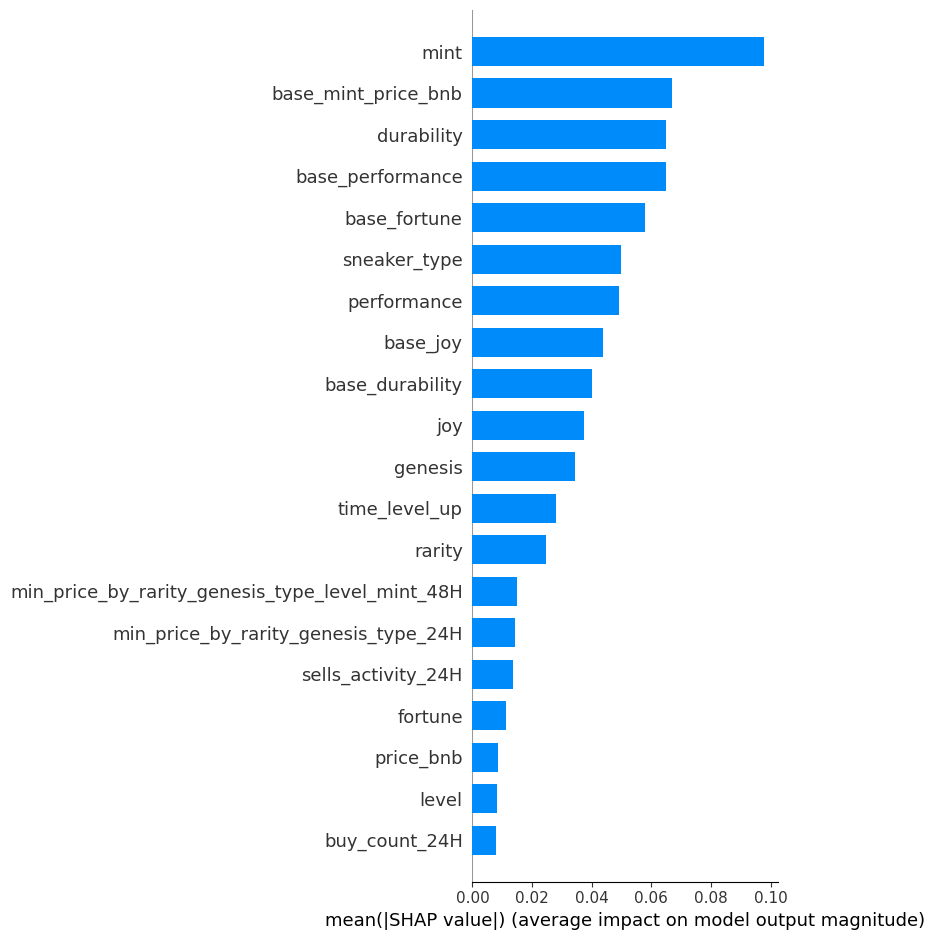

In [72]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [73]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.051566
0:	learn: 1.1260106	total: 3.59ms	remaining: 3.58s
1:	learn: 1.0832241	total: 6.96ms	remaining: 3.47s
2:	learn: 1.0430533	total: 9.06ms	remaining: 3.01s
3:	learn: 1.0051918	total: 10.9ms	remaining: 2.71s
4:	learn: 0.9689543	total: 12.6ms	remaining: 2.5s
5:	learn: 0.9338068	total: 14.3ms	remaining: 2.37s
6:	learn: 0.9014901	total: 16ms	remaining: 2.27s
7:	learn: 0.8705561	total: 17.7ms	remaining: 2.2s
8:	learn: 0.8397923	total: 19.3ms	remaining: 2.13s
9:	learn: 0.8138350	total: 21.2ms	remaining: 2.1s
10:	learn: 0.7880561	total: 22.9ms	remaining: 2.06s
11:	learn: 0.7643936	total: 24.7ms	remaining: 2.04s
12:	learn: 0.7403634	total: 26.4ms	remaining: 2s
13:	learn: 0.7198201	total: 28.1ms	remaining: 1.98s
14:	learn: 0.6988230	total: 29.9ms	remaining: 1.96s
15:	learn: 0.6797953	total: 31.6ms	remaining: 1.94s
16:	learn: 0.6615901	total: 33.3ms	remaining: 1.93s
17:	learn: 0.6427337	total: 35ms	remaining: 1.91s
18:	learn: 0.6244064	total: 36.7ms	remaining: 1.89s
19

In [74]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.907, 'MAE': 0.103, 'MSE': 0.074, 'RMSE': 0.272, 'MAPE': 0.075}

In [75]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.907, 'MAE': 0.103, 'MSE': 0.074, 'RMSE': 0.272, 'MAPE': 0.075}

In [76]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.907, 'MAE': 0.103, 'MSE': 0.074, 'RMSE': 0.272, 'MAPE': 0.075}

## Fit full Model

In [77]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.053791
0:	learn: 1.0668539	total: 2.61ms	remaining: 2.61s
1:	learn: 1.0255718	total: 5.06ms	remaining: 2.52s
2:	learn: 0.9871854	total: 7.72ms	remaining: 2.56s
3:	learn: 0.9493619	total: 10.1ms	remaining: 2.52s
4:	learn: 0.9119293	total: 12ms	remaining: 2.39s
5:	learn: 0.8798527	total: 14ms	remaining: 2.32s
6:	learn: 0.8489116	total: 16ms	remaining: 2.27s
7:	learn: 0.8182953	total: 17.9ms	remaining: 2.21s
8:	learn: 0.7902742	total: 19.7ms	remaining: 2.17s
9:	learn: 0.7628641	total: 21.7ms	remaining: 2.15s
10:	learn: 0.7351530	total: 23.7ms	remaining: 2.13s
11:	learn: 0.7116606	total: 25.5ms	remaining: 2.1s
12:	learn: 0.6889510	total: 27.3ms	remaining: 2.07s
13:	learn: 0.6671285	total: 29.2ms	remaining: 2.05s
14:	learn: 0.6461455	total: 31ms	remaining: 2.03s
15:	learn: 0.6279525	total: 32.7ms	remaining: 2.01s
16:	learn: 0.6106652	total: 34.7ms	remaining: 2.01s
17:	learn: 0.5942521	total: 36.7ms	remaining: 2s
18:	learn: 0.5763358	total: 38.7ms	remaining: 2s
19:	lea

### Test

In [78]:
i=1800

In [79]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                           ranger
genesis                                                 False
level                                                       0
base_performance                                          3.0
base_fortune                                              1.6
base_joy                                                  8.5
base_durability                                           8.3
performance                                               3.0
fortune                                                   1.6
joy                                                       8.5
durability                                                8.3
mint                                                      0.0
buy_count_24H                                             291
min_price_all_24H                                        0.69
sells_activity_24H                                   2.027491
min_pric

In [80]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [81]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.938

In [82]:
data.iloc[i]['price']

0.95

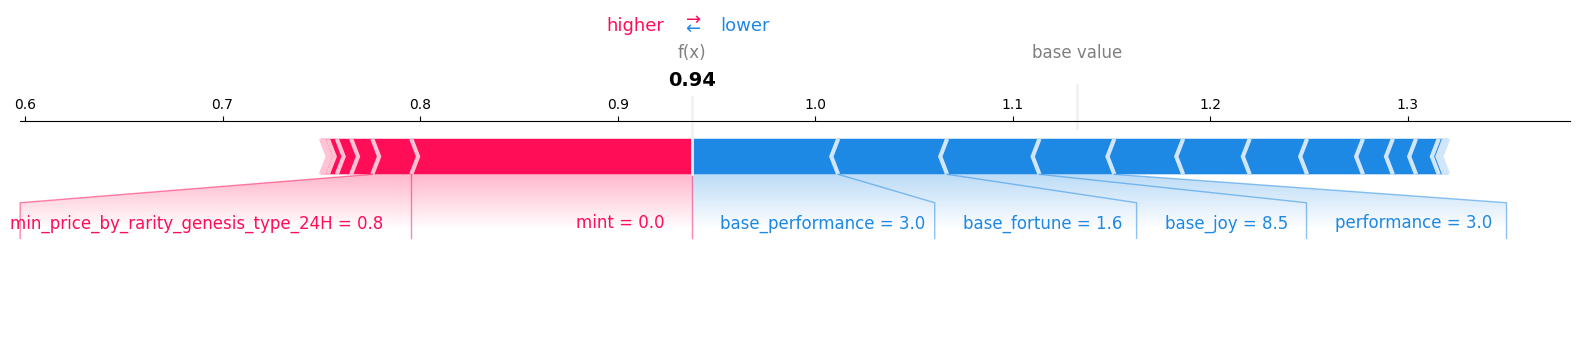

In [83]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [84]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [85]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [86]:
X.genesis.value_counts()

False    4107
True     1519
Name: genesis, dtype: int64

In [87]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5621,common,hiker,True,5,9.5,7.2,5.9,7.5,29.5,10.7,8.9,11.5,2.0
5622,common,hiker,True,5,7.2,2.8,6.6,5.8,25.7,4.3,10.1,8.8,2.0
5623,common,hiker,True,6,5.3,6.8,9.0,7.8,26.3,11.0,14.4,12.6,2.0
5624,common,ranger,False,0,8.8,9.0,3.7,1.4,8.8,9.0,3.7,1.4,0.0


In [88]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

30it [00:46,  1.54s/it]


In [89]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.887,0.0600
MAE,0.114,0.0156
MSE,0.162,0.1329
RMSE,0.378,0.1415
MAPE,0.077,0.0072


In [90]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.887,0.0600
MAE,0.114,0.0156
MSE,0.162,0.1329
RMSE,0.378,0.1415
MAPE,0.077,0.0072


In [91]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.882, 'MAE': 0.114, 'MSE': 0.163, 'RMSE': 0.403, 'MAPE': 0.077}

In [92]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

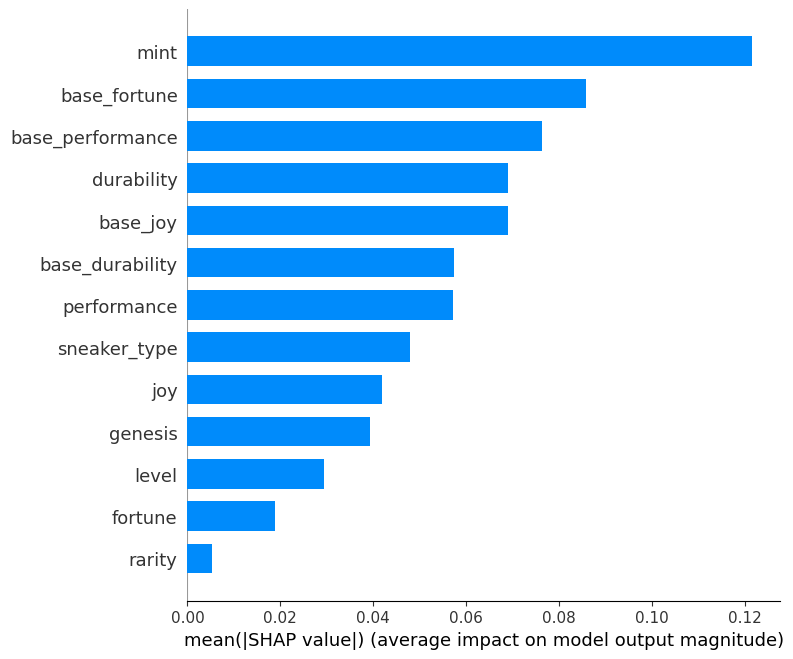

In [93]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

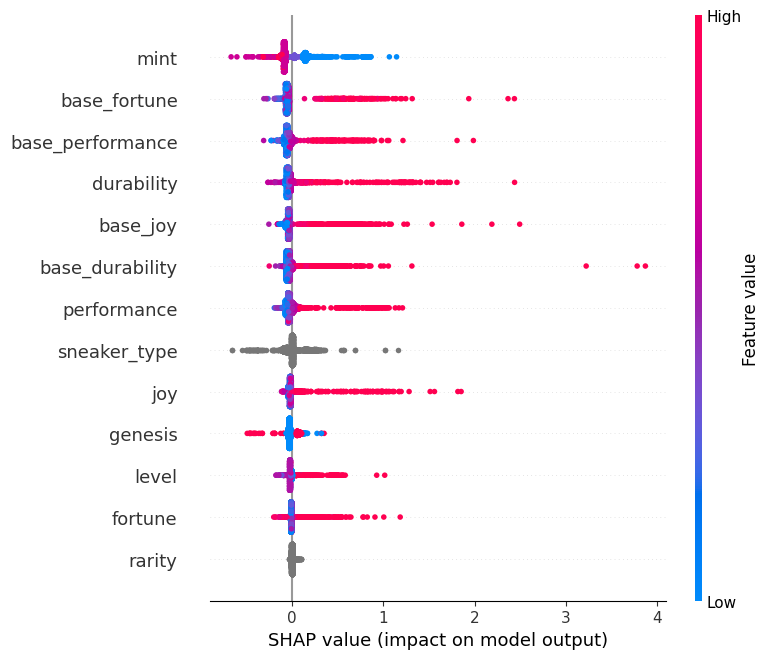

In [94]:
shap.summary_plot(shap_values, train_x,)

## TEST

In [95]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.051566
0:	learn: 1.1262706	total: 2.75ms	remaining: 2.75s
1:	learn: 1.0811730	total: 5.42ms	remaining: 2.7s
2:	learn: 1.0403258	total: 7.73ms	remaining: 2.57s
3:	learn: 1.0019003	total: 9.37ms	remaining: 2.33s
4:	learn: 0.9642801	total: 11ms	remaining: 2.2s
5:	learn: 0.9288918	total: 12.5ms	remaining: 2.07s
6:	learn: 0.8955548	total: 14.1ms	remaining: 1.99s
7:	learn: 0.8647456	total: 15.7ms	remaining: 1.94s
8:	learn: 0.8342122	total: 17.3ms	remaining: 1.91s
9:	learn: 0.8061295	total: 18.9ms	remaining: 1.87s
10:	learn: 0.7802276	total: 20.2ms	remaining: 1.82s
11:	learn: 0.7550669	total: 21.7ms	remaining: 1.79s
12:	learn: 0.7306251	total: 22.8ms	remaining: 1.73s
13:	learn: 0.7082825	total: 24.4ms	remaining: 1.72s
14:	learn: 0.6873631	total: 26ms	remaining: 1.71s
15:	learn: 0.6680481	total: 27.5ms	remaining: 1.69s
16:	learn: 0.6493062	total: 29ms	remaining: 1.68s
17:	learn: 0.6323988	total: 30.6ms	remaining: 1.67s
18:	learn: 0.6145952	total: 33.4ms	remaining: 1.72s


{'R2': 0.898, 'MAE': 0.121, 'MSE': 0.082, 'RMSE': 0.286, 'MAPE': 0.091}

## Fit full Base model

In [96]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

Learning rate set to 0.053791
0:	learn: 1.0653160	total: 2.39ms	remaining: 2.39s
1:	learn: 1.0231918	total: 4.6ms	remaining: 2.3s
2:	learn: 0.9820193	total: 7.1ms	remaining: 2.36s
3:	learn: 0.9420383	total: 9.55ms	remaining: 2.38s
4:	learn: 0.9065955	total: 11.5ms	remaining: 2.29s
5:	learn: 0.8718723	total: 13.4ms	remaining: 2.22s
6:	learn: 0.8396466	total: 15.1ms	remaining: 2.15s
7:	learn: 0.8090555	total: 16.9ms	remaining: 2.09s
8:	learn: 0.7807634	total: 18.6ms	remaining: 2.05s
9:	learn: 0.7539475	total: 20.4ms	remaining: 2.02s
10:	learn: 0.7293158	total: 22.2ms	remaining: 1.99s
11:	learn: 0.7052210	total: 23.8ms	remaining: 1.96s
12:	learn: 0.6820587	total: 25.7ms	remaining: 1.95s
13:	learn: 0.6601649	total: 27.4ms	remaining: 1.93s
14:	learn: 0.6399957	total: 29.2ms	remaining: 1.92s
15:	learn: 0.6212425	total: 30.9ms	remaining: 1.9s
16:	learn: 0.6027858	total: 32.7ms	remaining: 1.89s
17:	learn: 0.5852768	total: 34.5ms	remaining: 1.88s
18:	learn: 0.5685454	total: 36.4ms	remaining: 1.

### Test

In [97]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [98]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.587

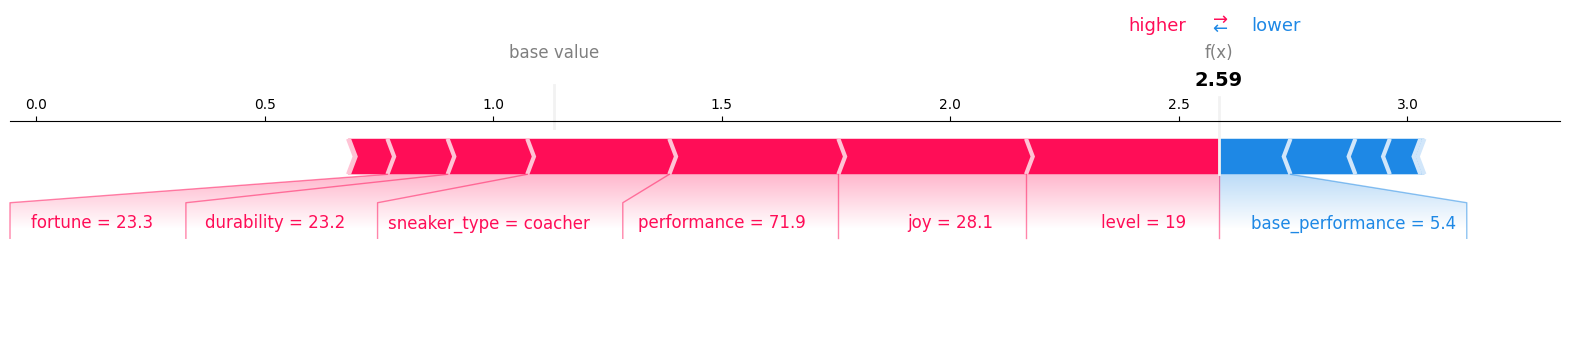

In [99]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

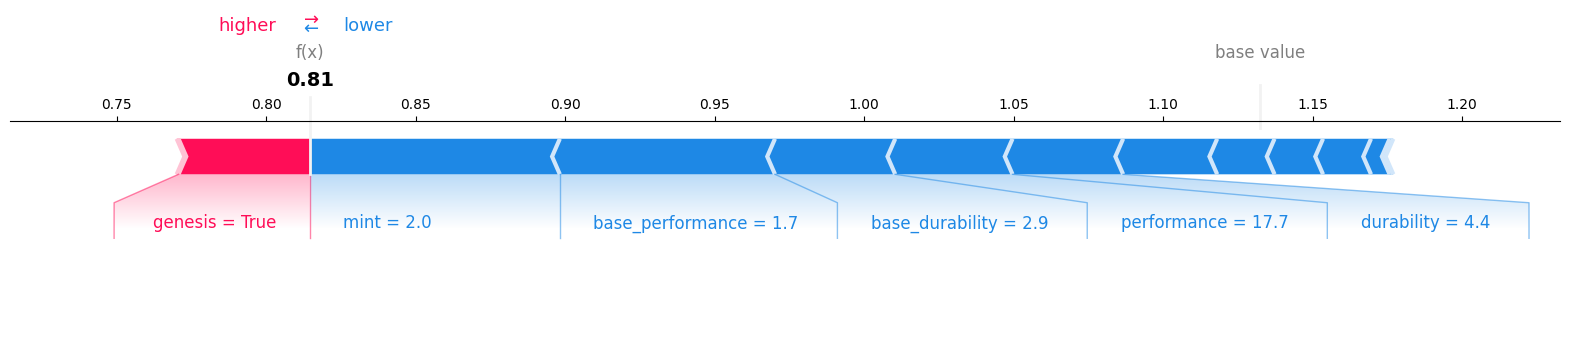

In [100]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [101]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [102]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

In [103]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [104]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663727805,35123,54829,buy,0x10787b0d56491edd99e54595b68716c5cd32da29,0x25f4920ab5abcf6aa9e5a63be96211546a3bc27c,1.14,box,common,NaN,...,404.0,8242.0,777,0,453,3038,5967,10576,85.0,1.073171
1,1663727265,35176,54857,buy,0xb15e57eb2f1840d42e7272fdd2175239e673df64,0x26d409a0bdef03cef0fabc738b12df86d8a40ce7,1.17,box,common,NaN,...,408.0,8240.0,779,0,453,3037,5967,10575,86.0,1.097561
2,1663725323,5414,17277,buy,0xf13d7625bf1838c14af331c5a5014aea39cc9a8c,0x26d409a0bdef03cef0fabc738b12df86d8a40ce7,1.80,box,common,NaN,...,414.0,8240.0,780,0,453,3038,5969,10575,86.0,1.047619
3,1663714738,34628,54225,buy,0x9bcff28bb4cd1e9d2bf0db6e07ba56251d2d8f0d,0x141039ae81d48259417e62ea83d77623c98824b0,1.17,box,common,NaN,...,424.0,8233.0,781,0,461,3026,5958,10560,85.0,1.023810
4,1663708442,35033,54768,buy,0xf985c5e862aeddea5faedabb639eed7629696cba,0x9f8be06ca280464c3f76444950e0bc7b2bf137b7,1.11,box,common,NaN,...,446.0,8229.0,780,0,493,3023,5956,10551,83.0,0.976190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
892,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
893,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
894,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [105]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [106]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [107]:
len(data)

896

In [108]:
len(data[data.date >= START_DATE])

530

In [109]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [110]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
525,1.660845e+09,3188.0,9.0,5.0,NaN,1800.0,300.0,200.0,0.667124
526,1.660754e+09,31448.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.665964
527,1.657800e+09,4000151.0,5.0,4.0,NaN,1800.0,300.0,200.0,0.661472
528,1.660482e+09,12362.0,11.0,10.0,NaN,1800.0,300.0,200.0,0.657919


In [111]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
525,1663708442,35033,54768,buy,False,sprinter,ranger,2022-09-20 21:14:02
526,1663714738,34628,54225,buy,False,coacher,hiker,2022-09-20 22:58:58
527,1663725323,5414,17277,buy,True,NaN,NaN,2022-09-21 01:55:23
528,1663727265,35176,54857,buy,False,hiker,hiker,2022-09-21 02:27:45


In [112]:
data.genesis.value_counts()

False    489
True      41
Name: genesis, dtype: int64

In [113]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [114]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [115]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [116]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,1663708442,35033,54768,buy,0xf985c5e862aeddea5faedabb639eed7629696cba,0x9f8be06ca280464c3f76444950e0bc7b2bf137b7,1.11,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
526,1663714738,34628,54225,buy,0x9bcff28bb4cd1e9d2bf0db6e07ba56251d2d8f0d,0x141039ae81d48259417e62ea83d77623c98824b0,1.17,box,common,NaN,...,0,0,0,0,0,1,0,0,0,0
527,1663725323,5414,17277,buy,0xf13d7625bf1838c14af331c5a5014aea39cc9a8c,0x26d409a0bdef03cef0fabc738b12df86d8a40ce7,1.80,box,common,NaN,...,0,0,0,0,0,0,0,0,0,0
528,1663727265,35176,54857,buy,0xb15e57eb2f1840d42e7272fdd2175239e673df64,0x26d409a0bdef03cef0fabc738b12df86d8a40ce7,1.17,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0


In [117]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [118]:
data['ranger_hiker'].sum()

54

## FE

In [119]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [120]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [121]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [122]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

30it [00:16,  1.79it/s]


In [123]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.912,0.0924
MAE,0.057,0.0106
MSE,0.012,0.0063
RMSE,0.105,0.0275
MAPE,0.044,0.0080


In [124]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.912,0.0924
MAE,0.057,0.0106
MSE,0.012,0.0063
RMSE,0.105,0.0275
MAPE,0.044,0.0080


In [125]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.944, 'MAE': 0.057, 'MSE': 0.012, 'RMSE': 0.108, 'MAPE': 0.044}

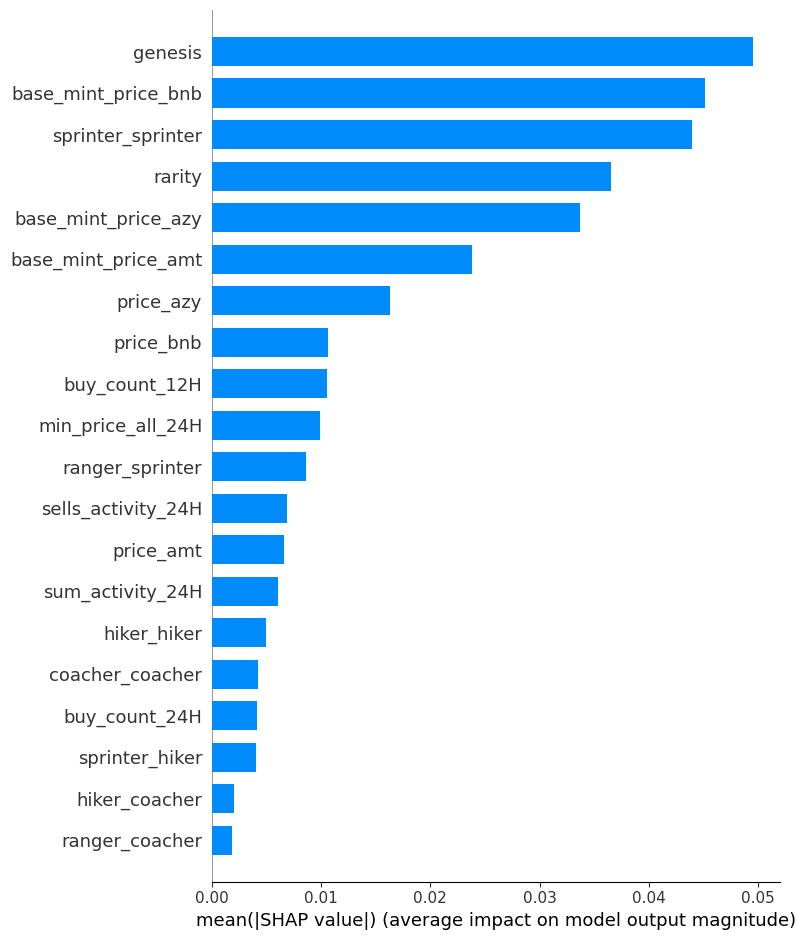

In [126]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [127]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.037035
0:	learn: 0.4464049	total: 835us	remaining: 835ms
1:	learn: 0.4376969	total: 1.85ms	remaining: 925ms
2:	learn: 0.4265338	total: 2.77ms	remaining: 920ms
3:	learn: 0.4157681	total: 3.65ms	remaining: 909ms
4:	learn: 0.4064769	total: 4.52ms	remaining: 900ms
5:	learn: 0.3987891	total: 5.37ms	remaining: 889ms
6:	learn: 0.3888713	total: 6.22ms	remaining: 883ms
7:	learn: 0.3791910	total: 7.09ms	remaining: 879ms
8:	learn: 0.3714336	total: 7.91ms	remaining: 871ms
9:	learn: 0.3622534	total: 8.76ms	remaining: 867ms
10:	learn: 0.3554827	total: 9.46ms	remaining: 851ms
11:	learn: 0.3468414	total: 9.75ms	remaining: 803ms
12:	learn: 0.3385324	total: 10.4ms	remaining: 792ms
13:	learn: 0.3337770	total: 11.1ms	remaining: 781ms
14:	learn: 0.3270762	total: 11.7ms	remaining: 767ms
15:	learn: 0.3203894	total: 12.3ms	remaining: 758ms
16:	learn: 0.3134585	total: 12.9ms	remaining: 747ms
17:	learn: 0.3071024	total: 13.5ms	remaining: 739ms
18:	learn: 0.3011145	total: 14.2ms	remaining:

### Test

In [128]:
i = 250

In [129]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2,
 'wallet_from_all_count': 9,
 'token_all_activity_3H': 0,
 'token_sell_activity_6H': 0,
 'buy_count_12H': 16,
 'buy_count_24H': 25,
 'buy_count_48H': 55,
 'sell_count_12H': 18,
 'sell_count_24H': 40,
 'sell_count_48H': 96,
 'cancel_count_12H': 9,
 'cancel_count_24H': 24,
 'cancel_count_

In [130]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H                16
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
base_mint_price_amt           0
base_mint_price_azy           0
base_mint_price_bnb           0
price_bnb                     0
price_azy                     0
price_amt                     0
ranger_sprinter               1
ranger_hiker                  0
ranger_coacher                0
sprinter_hiker                0
sprinter_coacher              0
hiker_coacher                 0
ranger_ranger                 0
sprinter_sprinter             0
hiker_hiker                   0
coacher_coacher               0
wallet_from_buy_count         2
wallet_from_all_count         9
dtype: object

In [131]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.143

In [132]:
data.iloc[i]['price']

1.0

In [133]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.448

In [134]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.486

# Box Base Model

In [135]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [136]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [137]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [138]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             530 non-null    object
 1   genesis            530 non-null    bool  
 2   ranger_sprinter    530 non-null    int64 
 3   ranger_hiker       530 non-null    int64 
 4   ranger_coacher     530 non-null    int64 
 5   sprinter_hiker     530 non-null    int64 
 6   sprinter_coacher   530 non-null    int64 
 7   hiker_coacher      530 non-null    int64 
 8   ranger_ranger      530 non-null    int64 
 9   sprinter_sprinter  530 non-null    int64 
 10  hiker_hiker        530 non-null    int64 
 11  coacher_coacher    530 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 46.2+ KB


In [139]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

30it [00:06,  4.77it/s]


In [140]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.889,0.0939
MAE,0.077,0.0149
MSE,0.018,0.0102
RMSE,0.127,0.0380
MAPE,0.060,0.0080


In [141]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.889,0.0939
MAE,0.077,0.0149
MSE,0.018,0.0102
RMSE,0.127,0.0380
MAPE,0.060,0.0080


In [142]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.916, 'MAE': 0.076, 'MSE': 0.018, 'RMSE': 0.133, 'MAPE': 0.06}

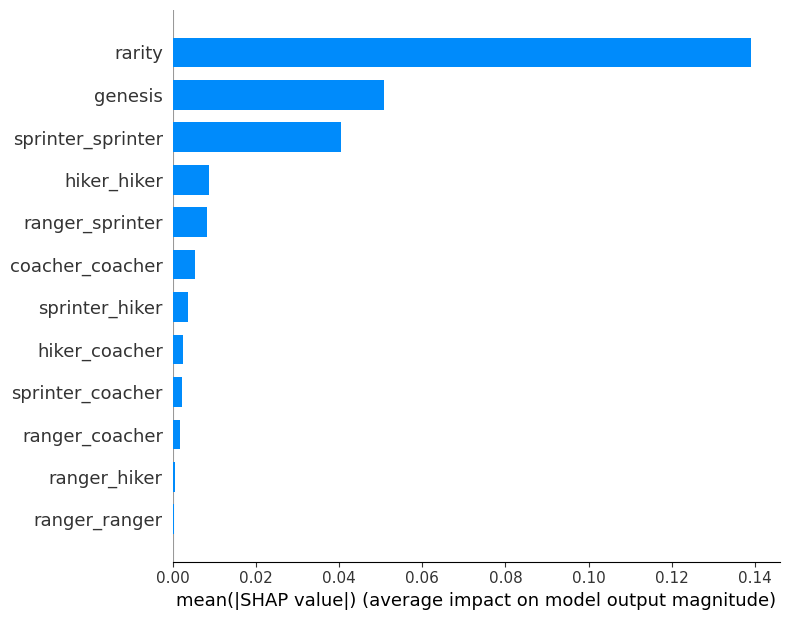

In [143]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [144]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.037035
0:	learn: 0.4449274	total: 232us	remaining: 233ms
1:	learn: 0.4317669	total: 441us	remaining: 220ms
2:	learn: 0.4199830	total: 593us	remaining: 197ms
3:	learn: 0.4086314	total: 840us	remaining: 209ms
4:	learn: 0.3996116	total: 1.07ms	remaining: 214ms
5:	learn: 0.3880314	total: 1.27ms	remaining: 210ms
6:	learn: 0.3778109	total: 1.42ms	remaining: 202ms
7:	learn: 0.3679749	total: 1.58ms	remaining: 196ms
8:	learn: 0.3585122	total: 1.74ms	remaining: 192ms
9:	learn: 0.3504549	total: 1.92ms	remaining: 190ms
10:	learn: 0.3406195	total: 2.12ms	remaining: 191ms
11:	learn: 0.3321455	total: 2.3ms	remaining: 189ms
12:	learn: 0.3240026	total: 2.47ms	remaining: 187ms
13:	learn: 0.3151299	total: 2.68ms	remaining: 189ms
14:	learn: 0.3075945	total: 2.86ms	remaining: 188ms
15:	learn: 0.2993310	total: 3.04ms	remaining: 187ms
16:	learn: 0.2912433	total: 3.29ms	remaining: 190ms
17:	learn: 0.2845358	total: 3.45ms	remaining: 188ms
18:	learn: 0.2770307	total: 3.67ms	remaining: 189

## Test

In [145]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.326

In [146]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [147]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter           0
ranger_hiker              0
ranger_coacher            0
sprinter_hiker            0
sprinter_coacher          0
hiker_coacher             0
ranger_ranger             0
sprinter_sprinter         0
hiker_hiker               0
coacher_coacher           0
dtype: object

In [148]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter           0
ranger_hiker              0
ranger_coacher            0
sprinter_hiker            1
sprinter_coacher          0
hiker_coacher             0
ranger_ranger             0
sprinter_sprinter         0
hiker_hiker               0
coacher_coacher           0
dtype: object

In [149]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.058

In [150]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [151]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.188

In [152]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.467

In [153]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.125

In [154]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.085

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [155]:
# import ast
# import json

In [156]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [157]:
# print(json.dumps(json_data))

In [158]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [159]:
#output = json.loads(r.text)

In [160]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам